## Test CNN

The objective of this notebook is test the usability of the processed data in a toy CNN

In [1]:
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib.pyplot as plt
import os
import json

random_seed = 42

Load pre processed data:

In [2]:
DATA_DIR = os.path.realpath(os.path.join(os.path.abspath(''),'../../datasets'))
PP_DATA_DIR = os.path.join(DATA_DIR, '184A1_hannah_EU_regression')
pp_data_files = os.listdir(PP_DATA_DIR)
pp_data_files

['val_metadata.csv',
 'params.json',
 'train_dataset.npy',
 'test_dataset.npy',
 'test_metadata.csv',
 'val_dataset.npy',
 'train_metadata.csv',
 'channels.csv',
 'metadata.csv']

In [3]:
# Load precessed data and metadata
metadata_dict = {}
data_dict = {}
for f in pp_data_files:
    f_name = f.split(".")[0]
    f_type = f.split(".")[1]
    if f_type == 'csv':
        metadata_dict[f_name] = pd.read_csv(os.path.join(PP_DATA_DIR, f))
        metadata_dict[f_name] = metadata_dict[f_name].loc[:, ~metadata_dict[f_name].columns.str.contains("Unnamed")]
    elif f_type == 'npy':
        data_dict[f_name] = np.load(os.path.join(PP_DATA_DIR, f), allow_pickle=True)
        
metadata_dict['channels'].set_index(['channel_id'], inplace=True)

# Load parameters used to process data
with open(os.path.join(PP_DATA_DIR, 'params.json')) as params_file:
    p = json.load(params_file)

In [4]:
p.keys()

dict_keys(['data_dirs', 'dir_type', 'seed', 'input_channels', 'output_channels', 'aggregate_output', 'train_frac', 'val_frac', 'img_size', 'background_value', 'normalise', 'percentile', 'add_cell_cycle_to_metadata', 'cell_cycle_file', 'add_well_info_to_metadata', 'well_info_file', 'filter_criteria', 'filter_values', 'normalise_rescale_values'])

In [5]:
metadata_dict.keys()

dict_keys(['val_metadata', 'test_metadata', 'train_metadata', 'channels', 'metadata'])

In [6]:
data_dict.keys()

dict_keys(['train_dataset', 'test_dataset', 'val_dataset'])

In [7]:
metadata_dict['channels'].shape

(34, 1)

In [8]:
x_train = data_dict['train_dataset'][:,:,:,:-1]
#y_train = data_dict['train_dataset'][:,:,:,-1]

x_val = data_dict['val_dataset'][:,:,:,:-1]
#y_val = data_dict['val_dataset'][:,:,:,-1]

x_test = data_dict['test_dataset'][:,:,:,:-1]
#y_test = data_dict['test_dataset'][:,:,:,-1]

n_train, _, _, n_channels = x_train.shape
print('Number of channels:{}\nNumber of training images: {}'.format(n_channels, n_train))

Number of channels:33
Number of training images: 465


In [9]:
# Process responce variable, for now we will take the average of the measured pixels
y_train = np.array([img[img!=0].mean() for img in data_dict['train_dataset'][:,:,:,-1]])
y_val = np.array([img[img!=0].mean() for img in data_dict['val_dataset'][:,:,:,-1]])
y_test = np.array([img[img!=0].mean() for img in data_dict['test_dataset'][:,:,:,-1]])

## Normalize data

In [10]:
def Normalize_channel(a, min_val, max_val):
    return (a - min_val) / (max_val - min_val)

# Get the min and max values per channel from the training set
train_min = np.amin(x_train, axis=(0,1,2))
train_max = np.amax(x_train, axis=(0,1,2))

# Normalize each channel of the train, val and test datasets using
# the min and max values obteained from the train dataset
for c in range(n_channels):
    x_train[:,:,:,c] = Normalize_channel(x_train[:,:,:,c], train_min[c], train_max[c])
    x_val[:,:,:,c] = Normalize_channel(x_val[:,:,:,c], train_min[c], train_max[c])
    x_test[:,:,:,c] = Normalize_channel(x_test[:,:,:,c], train_min[c], train_max[c])

Lets plot some cells

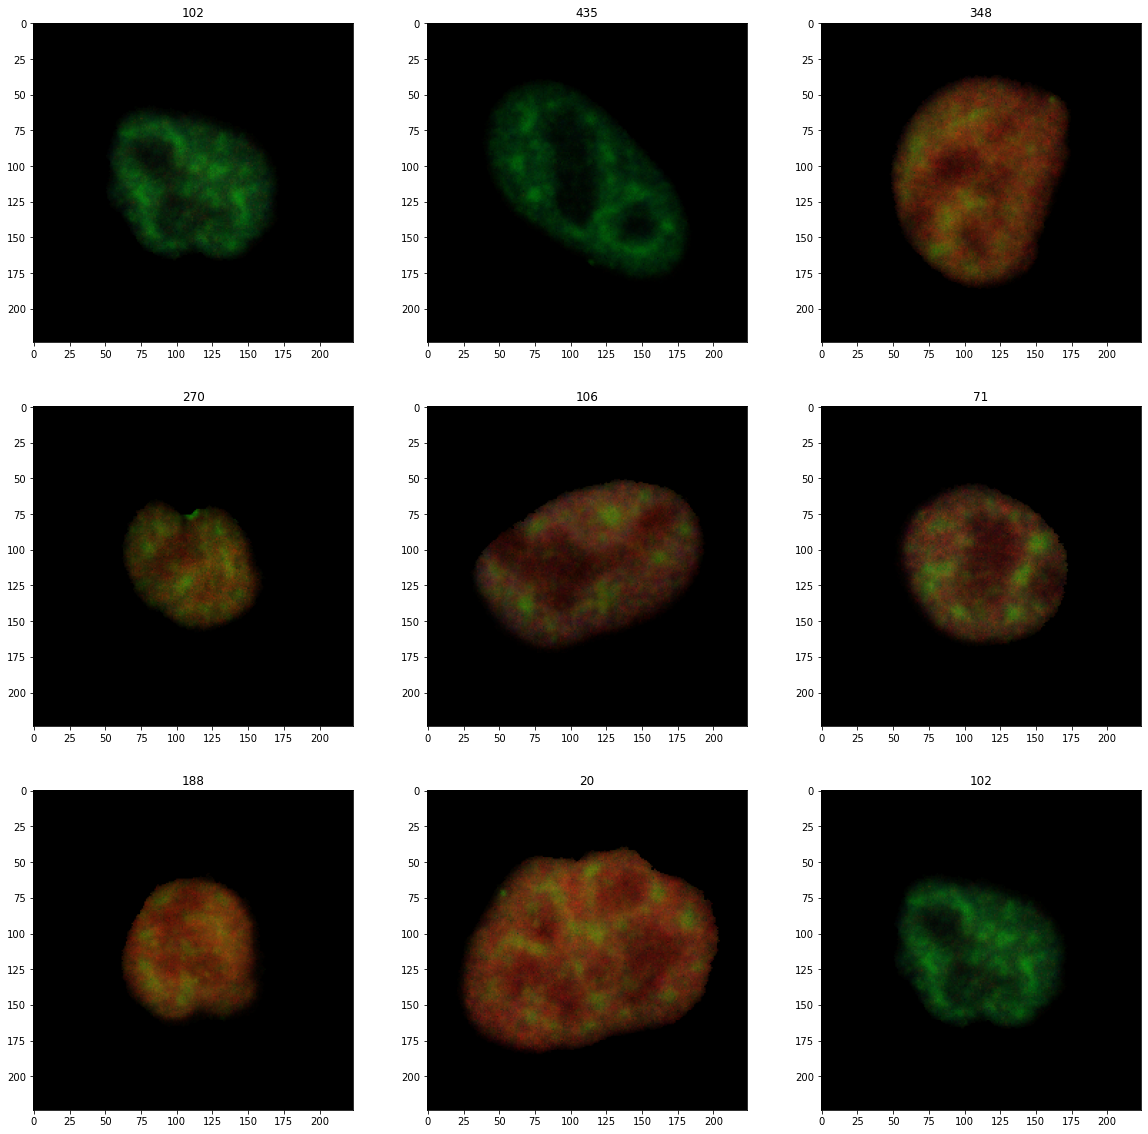

In [11]:
np.random.seed(p['seed'])
plt.figure(figsize=(20,20))
for i in range(9):
    img_index = np.random.randint(0,n_train,1)[0]
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[img_index,:,:,10:13], 
               #cmap=plt.cm.binary,
               cmap=plt.cm.PiYG,
               vmin=0, vmax=1,
               #alpha=1
              )
    plt.title(img_index)

Model:

In [12]:
import tensorflow as tf

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), 
                           padding='same',
                           activation=tf.nn.relu, 
                           input_shape=(p['img_size'], p['img_size'], n_channels)),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    
    tf.keras.layers.Conv2D(128, (3,3),
                           padding='same', 
                           activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(1)
    
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.Huber(delta=1.0),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      19072     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               102760704 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

In [21]:
#data = tf.data.Dataset.from_tensors((x_train, y_train))
data = tf.data.Dataset.from_tensor_slices((x_train, y_train))

In [22]:
type(data)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

In [23]:
data

<TensorSliceDataset shapes: ((224, 224, 33), ()), types: (tf.float32, tf.float32)>

In [24]:
for img, lab in data.take(1):
    break

()


In [27]:
lab

<tf.Tensor: shape=(), dtype=float32, numpy=0.86876696>

In [16]:
tf.data.Dataset.from_tensors?

In [120]:
#BATCH_SIZE = 32
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
15/15 [==============================] - 39s 3s/step - loss: 0.0155 - accuracy: 0.0000e+00
Epoch 2/5
15/15 [==============================] - 41s 3s/step - loss: 0.0058 - accuracy: 0.0000e+00
Epoch 3/5
15/15 [==============================] - 37s 2s/step - loss: 0.0042 - accuracy: 0.0000e+00
Epoch 4/5
15/15 [==============================] - 38s 3s/step - loss: 0.0032 - accuracy: 0.0000e+00
Epoch 5/5
15/15 [==============================] - 39s 3s/step - loss: 0.0029 - accuracy: 0.0000e+00
